# Setup

In [35]:
# Enable auto-reloading of imports when they have been modified
from IPython import get_ipython
ipython = get_ipython(); assert ipython is not None
ipython.run_line_magic("load_ext", "autoreload")
ipython.run_line_magic("autoreload", "2")

import os
import json
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys
import plotly.express as px
import plotly.graph_objects as go
from tqdm.notebook import tqdm

# Disable gradient computation - this notebook will only perform forward passes
torch.set_grad_enabled(False)

from pathlib import Path
import sys
import os

# Add the base (root) directory to the path so we can import the util modules
def get_base_folder(project_root = "Count_PIPNet"):
	# Find the project root dynamically
	current_dir = os.getcwd()
	while True:
		if os.path.basename(current_dir) == project_root:  # Adjust to match your project root folder name
			break
		parent = os.path.dirname(current_dir)
		if parent == current_dir:  # Stop if we reach the system root (failsafe)
			raise RuntimeError(f"Project root {project_root} not found. Check your folder structure.")
		current_dir = parent

	return Path(current_dir)

base_path = get_base_folder()
print(f"Base path: {base_path}")
sys.path.append(str(base_path))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Base path: /mnt/ssd-1/mechinterp/taras/Count_PIPNet


In [2]:
from util.vis_pipnet import visualize_topk
from pipnet.count_pipnet import get_count_network
from util.checkpoint_manager import CheckpointManager
from util.data import get_dataloaders
from util.args import get_args
from util.vis_pipnet import visualize_topk

In [3]:
# Device setup
GPU_TO_USE = 2

if torch.backends.mps.is_available():
    device = "mps"
else:
    device = f"cuda:{GPU_TO_USE}" if torch.cuda.is_available() else "cpu"

print(f'>>> Using {device} device <<<')

>>> Using cuda:2 device <<<


# Loading utilities

In [8]:
# Function to load a model from a checkpoint
def load_model(run_dir, checkpoint_name='net_trained_best', base_path=base_path, gpu_id=GPU_TO_USE):
    """
    Load a model from a checkpoint directory for evaluation purposes.

    Args:
        run_dir: Directory containing the run results
        checkpoint_name: Name of checkpoint to load (default: 'net_trained_best')
        base_path: Base path for dataset directories
        gpu_id: GPU ID to use
        
    Returns:
        Tuple of (net, trainloader, testloader, classes, args, is_count_pipnet)
    """
    # Step 1: Load the configuration used for this run
    metadata_dir = os.path.join(run_dir, 'metadata')
    args_path = os.path.join(metadata_dir, 'args.pickle')

    import pickle
    with open(args_path, 'rb') as f:
        args = pickle.load(f)
    print(f"Loaded configuration from {args_path}")

    # Explicitly set GPU ID to ensure device consistency
    if torch.cuda.is_available():
        args.gpu_ids = str(gpu_id)
        device = torch.device(f'cuda:{gpu_id}')
        torch.cuda.set_device(device)
    else:
        device = torch.device('cpu')

    print(f"Using device: {device}")

    # Step 2: Create dataloaders
    args.log_dir = run_dir  # Use the run directory as log_dir
    trainloader, trainloader_pretraining, trainloader_normal, \
    trainloader_normal_augment, projectloader, testloader, test_projectloader, classes = get_dataloaders(args, device, base_path)

    # Step 3: Create a model with the same architecture
    if hasattr(args, 'model') and args.model == 'count_pipnet':
        is_count_pipnet = True
        net, num_prototypes = get_count_network(
            num_classes=len(classes), 
            args=args,
            max_count=getattr(args, 'max_count', 3),
            use_ste=getattr(args, 'use_ste', False))
    else:
        is_count_pipnet = False
        net, num_prototypes = get_pipnet(len(classes), args)

    # Step 4: Move model to device
    net = net.to(device)

    # Step 5: Forward one batch through the backbone to get the latent output size
    with torch.no_grad():
        # Use a small batch to determine output shape
        xs1, _, _ = next(iter(trainloader))
        xs1 = xs1.to(device)

        # Single-forward pass without DataParallel
        features = net._net(xs1)
        proto_features = net._add_on(features)

        wshape = proto_features.shape[-1]
        args.wshape = wshape  # needed for calculating image patch size
        print(f"Output shape: {proto_features.shape}, setting wshape={wshape}")
            
    # Step 6: Now wrap with DataParallel
    device_ids = [gpu_id]
    print(f"Using device_ids: {device_ids}")
    net = nn.DataParallel(net, device_ids=device_ids)

    # Step 7: Direct checkpoint loading
    checkpoint_path = os.path.join(run_dir, 'checkpoints', checkpoint_name)
    if not os.path.exists(checkpoint_path):
        print(f"Checkpoint not found at {checkpoint_path}, trying alternative paths...")
        # Try with full path as fallback
        if os.path.exists(checkpoint_name):
            checkpoint_path = checkpoint_name
        else:
            # Try other common checkpoint names
            alternatives = [
                os.path.join(run_dir, 'checkpoints', 'net_trained_last'),
                os.path.join(run_dir, 'checkpoints', 'net_trained'),
                checkpoint_name # in case the direct path was passed
            ]
            for alt_path in alternatives:
                if os.path.exists(alt_path):
                    checkpoint_path = alt_path
                    print(f"Found alternative checkpoint at {checkpoint_path}")
                    break
            else:
                print("No checkpoint found")
                return None, None, None, None, None, None

    try:
        # Load just the model state dict
        checkpoint = torch.load(checkpoint_path, map_location=device)
        
        if 'model_state_dict' in checkpoint:
            net.load_state_dict(checkpoint['model_state_dict'], strict=True)
            print(f"Successfully loaded model state from {checkpoint_path}")
            
            # Display additional information if available
            if 'epoch' in checkpoint:
                print(f"Checkpoint from epoch {checkpoint['epoch']}")
            if 'accuracy' in checkpoint:
                print(f"Model accuracy: {checkpoint['accuracy']:.4f}")
            
            return net, trainloader, testloader, classes, args, is_count_pipnet
        else:
            print(f"Checkpoint doesn't contain model_state_dict")
            return None, None, None, None, None, None
            
    except Exception as e:
        print(f"Error loading checkpoint: {str(e)}")
        import traceback
        traceback.print_exc()
        return None, None, None, None, None, None

# Evaluation utilities

In [43]:
import warnings
# Suppress SettingWithCopyWarning
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)
# Suppress FutureWarning
warnings.simplefilter(action='ignore', category=FutureWarning)

In [9]:
# Function to evaluate a model on the test set
def evaluate_model(net, testloader, device, args):
    """
    Evaluate a model on the test set.
    
    Args:
        net: The model to evaluate
        testloader: DataLoader for the test set
        device: Device to run evaluation on
        args: Arguments object containing parameters
        
    Returns:
        Dictionary containing evaluation metrics
    """
    print("Evaluating model on test set...")
    net.eval()
    
    # Set enforce_weight_sparsity parameter based on args if available
    enforce_weight_sparsity = getattr(args, 'enforce_weight_sparsity', True)
    
    # Call the evaluation function from pipnet.test
    eval_info = eval_pipnet(net, testloader, "evaluation", device, log=None, 
                           enforce_weight_sparsity=enforce_weight_sparsity, args=args)
    
    print(f"Evaluation completed. Top-1 accuracy: {eval_info['top1_accuracy']:.4f}")
    
    return eval_info

In [39]:
# Function to load and parse the log_epoch_overview.csv file
def load_training_metrics(run_dir):
    """
    Load the training metrics from the log_epoch_overview.csv file.
    
    Args:
        run_dir: Directory containing the run results
        
    Returns:
        pandas DataFrame containing the metrics
    """
    log_path = os.path.join(run_dir, 'log_epoch_overview.csv')
    
    if not os.path.exists(log_path):
        print(f"Log file not found at {log_path}")
        return None
    
    try:
        # Load the CSV file
        df = pd.read_csv(log_path)
        
        # Convert 'n.a.' strings to NaN
        df = df.replace('n.a.', np.nan)
        
        # Convert to numeric types where possible
        for col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='ignore')
        
        # Determine which epochs were pretraining
        pretraining_mask = df['test_top1_acc'].isna()
        df['phase'] = 'training'
        df.loc[pretraining_mask, 'phase'] = 'pretraining'
        
        # Calculate the real epoch number (pretraining + training)
        df['real_epoch'] = df.index + 1
        
        # Calculate the training epoch number (just for the training phase)
        training_epochs = (~pretraining_mask).cumsum()
        df.loc[~pretraining_mask, 'training_epoch'] = training_epochs[~pretraining_mask]
        
        return df
    
    except Exception as e:
        print(f"Error loading log file: {str(e)}")
        import traceback
        traceback.print_exc()
        return None

In [11]:
# Function to plot training metrics
def plot_training_metrics(df, output_dir, run_name=None):
    """
    Plot training metrics from the log_epoch_overview.csv file.
    
    Args:
        df: DataFrame containing the metrics
        output_dir: Directory to save the plots
        run_name: Name of the run (for labeling plots)
        
    Returns:
        Dictionary of plotly figure objects
    """
    if df is None:
        print("No metrics data to plot")
        return {}
    
    # Create directory for plots
    os.makedirs(output_dir, exist_ok=True)
    
    # Create figures dictionary
    figures = {}
    
    # Helper function to create and save a plot
    def create_metric_plot(y_col, title, y_axis_title, pretraining=False, use_training_epoch=False):
        if pretraining:
            data = df[df['phase'] == 'pretraining']
            x_col = 'real_epoch'
        else:
            data = df[df['phase'] == 'training']
            x_col = 'training_epoch' if use_training_epoch else 'real_epoch'
        
        if data[y_col].isna().all():
            print(f"No data for {y_col} in {'pretraining' if pretraining else 'training'} phase")
            return None
        
        fig = px.line(data, x=x_col, y=y_col, 
                     title=f"{title}{' - ' + run_name if run_name else ''}",
                     labels={'x': 'Epoch', 'y': y_axis_title})
        
        # Add horizontal line for best performance if applicable
        if y_col == 'test_top1_acc' and not pretraining:
            best_acc = data[y_col].max()
            best_epoch = data[data[y_col] == best_acc][x_col].values[0]
            
            fig.add_shape(
                type="line",
                x0=data[x_col].min(),
                x1=data[x_col].max(),
                y0=best_acc,
                y1=best_acc,
                line=dict(color="red", dash="dash"),
            )
            
            fig.add_annotation(
                x=best_epoch,
                y=best_acc,
                text=f"Best: {best_acc:.4f} at epoch {best_epoch}",
                showarrow=True,
                arrowhead=1,
            )
        
        # Save the plot
        if pretraining:
            fig_path = os.path.join(output_dir, f"pretraining_{y_col}.html")
        else:
            fig_path = os.path.join(output_dir, f"training_{y_col}.html")
        
        fig.write_html(fig_path)
        
        return fig
    
    # Plot test accuracy 
    figures['test_accuracy'] = create_metric_plot(
        'test_top1_acc', 'Test Accuracy', 'Accuracy', pretraining=False, use_training_epoch=True
    )
    
    # Plot number of non-zero prototypes
    figures['num_nonzero_prototypes'] = create_metric_plot(
        'num_nonzero_prototypes', 'Number of Non-Zero Prototypes', 'Count', pretraining=False, use_training_epoch=True
    )
    
    # Plot local size for all classes
    figures['local_size_all_classes'] = create_metric_plot(
        'local_size_all_classes', 'Local Size for All Classes', 'Size', pretraining=False, use_training_epoch=True
    )
    
    # Plot training loss components for pretraining
    pretraining_loss_cols = ['align_loss_raw', 'tanh_loss_raw']
    if any(df[df['phase'] == 'pretraining'][col].notna().any() for col in pretraining_loss_cols):
        pre_data = df[df['phase'] == 'pretraining']
        pre_data_melt = pd.melt(pre_data.reset_index(), 
                               id_vars=['index', 'real_epoch'], 
                               value_vars=pretraining_loss_cols,
                               var_name='Loss Component',
                               value_name='Value')
        
        fig = px.line(pre_data_melt, x='real_epoch', y='Value', 
                     color='Loss Component',
                     title=f"Pretraining Loss Components{' - ' + run_name if run_name else ''}",
                     labels={'real_epoch': 'Epoch', 'Value': 'Loss Value'})
        
        # Save the plot
        fig_path = os.path.join(output_dir, "pretraining_loss_components.html")
        fig.write_html(fig_path)
        figures['pretraining_loss_components'] = fig
    
    # Plot training loss components for training
    training_loss_cols = ['align_loss_raw', 'tanh_loss_raw', 'class_loss_raw']
    if any(df[df['phase'] == 'training'][col].notna().any() for col in training_loss_cols):
        train_data = df[df['phase'] == 'training']
        train_data_melt = pd.melt(train_data.reset_index(), 
                                 id_vars=['index', 'training_epoch'], 
                                 value_vars=training_loss_cols,
                                 var_name='Loss Component',
                                 value_name='Value')
        
        fig = px.line(train_data_melt, x='training_epoch', y='Value', 
                     color='Loss Component',
                     title=f"Training Loss Components{' - ' + run_name if run_name else ''}",
                     labels={'training_epoch': 'Epoch', 'Value': 'Loss Value'})
        
        # Save the plot
        fig_path = os.path.join(output_dir, "training_loss_components.html")
        fig.write_html(fig_path)
        figures['training_loss_components'] = fig
    
    # Plot prototype presence metrics
    prototype_metrics = ['almost_nonzeros_pooled', 'almost_sim_nonzeros']
    if any(df[df['phase'] == 'training'][col].notna().any() for col in prototype_metrics):
        train_data = df[df['phase'] == 'training']
        metrics_melt = pd.melt(train_data.reset_index(), 
                              id_vars=['index', 'training_epoch'], 
                              value_vars=prototype_metrics,
                              var_name='Metric',
                              value_name='Value')
        
        fig = px.line(metrics_melt, x='training_epoch', y='Value', 
                     color='Metric',
                     title=f"Prototype Activation Metrics{' - ' + run_name if run_name else ''}",
                     labels={'training_epoch': 'Epoch', 'Value': 'Count'})
        
        # Save the plot
        fig_path = os.path.join(output_dir, "prototype_activation_metrics.html")
        fig.write_html(fig_path)
        figures['prototype_activation'] = fig
    
    print(f"Plots saved to {output_dir}")
    return figures

In [37]:
def compare_models(run_dirs, output_dir, metric='test_top1_acc', display_in_notebook=True):
    """
    Compare multiple models based on a specific metric from their log files.
    
    Args:
        run_dirs: Dictionary mapping run names to run directories
        output_dir: Directory to save the comparison plot
        metric: Metric to compare (default: 'test_top1_acc')
        display_in_notebook: Whether to display the figure in the notebook
        
    Returns:
        plotly figure object
    """
    # Create a combined DataFrame
    combined_data = []
    
    for run_name, run_dir in run_dirs.items():
        df = load_training_metrics(run_dir)
        if df is not None:
            # Only use training phase data
            training_df = df[df['phase'] == 'training']
            if not training_df.empty and metric in training_df.columns:
                # Add run name for identification
                training_df['run'] = run_name
                combined_data.append(training_df[['training_epoch', metric, 'run']])
    
    if not combined_data:
        print("No data to compare")
        return None
    
    # Concatenate the DataFrames
    combined_df = pd.concat(combined_data, ignore_index=True)
    
    # Create comparison plot
    fig = px.line(combined_df, x='training_epoch', y=metric, 
                 color='run',
                 title=f"Comparison of {metric} Across Models",
                 labels={'training_epoch': 'Epoch', metric: metric})
    
    # Improve readability with grid and legend
    fig.update_layout(
        legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1),
        xaxis=dict(showgrid=True),
        yaxis=dict(showgrid=True)
    )
    
    # Save the plot
    fig_path = os.path.join(output_dir, f"comparison_{metric}.html")
    fig.write_html(fig_path)
    
    print(f"Comparison plot saved to {fig_path}")
    
    # Display the figure in the notebook if requested
    if display_in_notebook:
        from IPython.display import display
        display(fig)
    
    return fig

In [13]:
# Function to analyze a single run
def analyze_run(run_dir, output_dir, evaluate_test=True, checkpoint_name='net_trained_best'):
    """
    Analyze a single run by loading its model, evaluating on test set, and plotting metrics.
    
    Args:
        run_dir: Directory containing the run results
        output_dir: Directory to save analysis results
        evaluate_test: Whether to evaluate the model on the test set
        checkpoint_name: Name of checkpoint to load
        
    Returns:
        Dictionary containing analysis results
    """
    print(f"\n{'='*60}")
    print(f"Analyzing run: {os.path.basename(run_dir)}")
    print(f"{'='*60}")
    
    run_name = os.path.basename(run_dir)
    run_output_dir = os.path.join(output_dir, run_name)
    os.makedirs(run_output_dir, exist_ok=True)
    
    results = {'name': run_name, 'run_dir': run_dir}
    
    # Load training metrics
    df = load_training_metrics(run_dir)
    if df is not None:
        results['metrics_df'] = df
        
        # Plot training metrics
        figures = plot_training_metrics(df, run_output_dir, run_name)
        results['figures'] = figures
        
        # Extract best performance
        if 'test_top1_acc' in df.columns and not df['test_top1_acc'].isna().all():
            best_acc = df['test_top1_acc'].max()
            best_epoch = df[df['test_top1_acc'] == best_acc]['real_epoch'].values[0]
            results['best_accuracy'] = best_acc
            results['best_epoch'] = best_epoch
            print(f"Best accuracy from log: {best_acc:.4f} at epoch {best_epoch}")
    
    # Evaluate on test set if requested
    if evaluate_test:
        print("Loading model for test evaluation...")
        net, trainloader, testloader, classes, args, is_count_pipnet = load_model(
            run_dir, checkpoint_name=checkpoint_name
        )
        
        if net is not None:
            # Evaluate on test set
            eval_info = evaluate_model(net, testloader, device, args)
            results['eval_info'] = eval_info
            
            # Save evaluation results
            eval_results_path = os.path.join(run_output_dir, 'test_evaluation.json')
            with open(eval_results_path, 'w') as f:
                # Convert any non-serializable objects to strings
                serializable_info = {}
                for k, v in eval_info.items():
                    if isinstance(v, (int, float, str, bool, list, dict)) or v is None:
                        serializable_info[k] = v
                    else:
                        serializable_info[k] = str(v)
                        
                json.dump(serializable_info, f, indent=2)
                
            print(f"Test evaluation results saved to {eval_results_path}")
    
    return results

# Loading the models

In [23]:
# Define the base directory for your experiments
multi_experiment_dir = base_path / 'runs/multi_stage' 
print(f"Experiment directory: {multi_experiment_dir}")

Experiment directory: /mnt/ssd-1/mechinterp/taras/Count_PIPNet/runs/multi_stage


In [24]:
# Create a directory for saving evaluation results
eval_results_dir = base_path / 'evaluations'
os.makedirs(eval_results_dir, exist_ok=True)
print(f"Evaluation results will be saved to {eval_results_dir}")

Evaluation results will be saved to /mnt/ssd-1/mechinterp/taras/Count_PIPNet/evaluations


In [25]:
summary_path = os.path.join(multi_experiment_dir, 'summary.json')

try:
	# Load the summary file to get all run directories
	with open(summary_path, 'r') as f:
		summary = json.load(f)

	print(f"Found {len(summary)} trained models")
except FileNotFoundError:
    summary = None
    print(f"Summary file NOT found at {summary_path}. Please ensure the training was completed and the summary file was generated.")

Summary file NOT found at /mnt/ssd-1/mechinterp/taras/Count_PIPNet/runs/multi_stage/summary.json. Please ensure the training was completed and the summary file was generated.


In [28]:
# Option to use hard-coded run directories (specify just the base names)
hard_coded_run_dirs = [
    '45_shapesGN_linear',
    '45_shapesGN_onehot'
]

if hard_coded_run_dirs:
    # Convert base names to full paths (assume they're in the 'runs/' folder)
    run_dirs = {}
    for run_name in hard_coded_run_dirs:
        full_path = base_path / 'runs' / run_name
        if os.path.isdir(full_path) and os.path.exists(os.path.join(full_path, 'metadata')):
            run_dirs[run_name] = str(full_path)
        else:
            print(f"Warning: Run directory '{run_name}' not found at {full_path}")
    print(f"Using {len(run_dirs)} manually specified run directories")
elif summary is None:
    run_dirs = {}
    for item in os.listdir(multi_experiment_dir):
        item_path = os.path.join(multi_experiment_dir, item)
        if os.path.isdir(item_path) and os.path.exists(os.path.join(item_path, 'metadata')):
            run_dirs[item] = item_path
    print(f"Found {len(run_dirs)} run directories")
else:
    # Use the runs from the summary file
    run_dirs = {os.path.basename(run['output_dir']): run['output_dir'] for run in summary}

Using 2 manually specified run directories


In [29]:
run_dirs

{'45_shapesGN_linear': '/mnt/ssd-1/mechinterp/taras/Count_PIPNet/runs/45_shapesGN_linear',
 '45_shapesGN_onehot': '/mnt/ssd-1/mechinterp/taras/Count_PIPNet/runs/45_shapesGN_onehot'}

# Main part (single seed)

## Plotting validation metrics


Comparing models...
Comparison plot saved to /mnt/ssd-1/mechinterp/taras/Count_PIPNet/evaluations/comparison_test_top1_acc.html


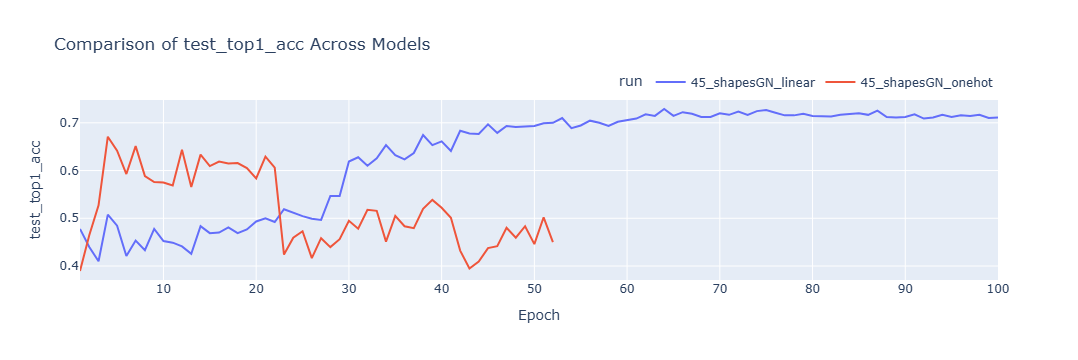

Comparison plot saved to /mnt/ssd-1/mechinterp/taras/Count_PIPNet/evaluations/comparison_num_nonzero_prototypes.html


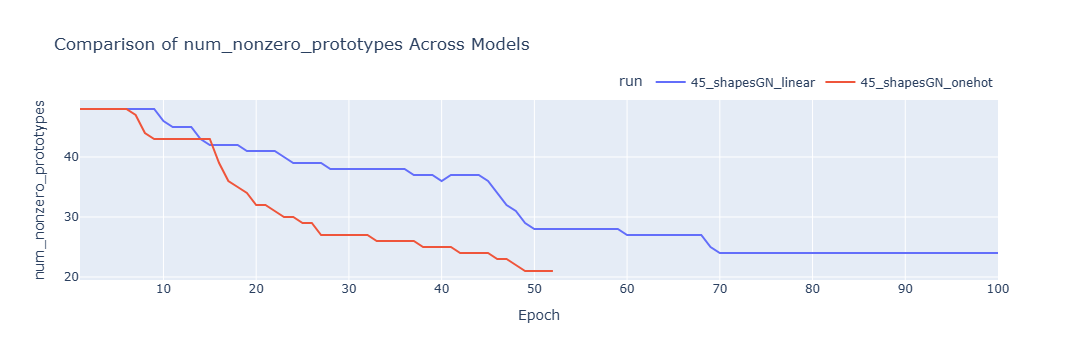

Comparison plot saved to /mnt/ssd-1/mechinterp/taras/Count_PIPNet/evaluations/comparison_local_size_all_classes.html


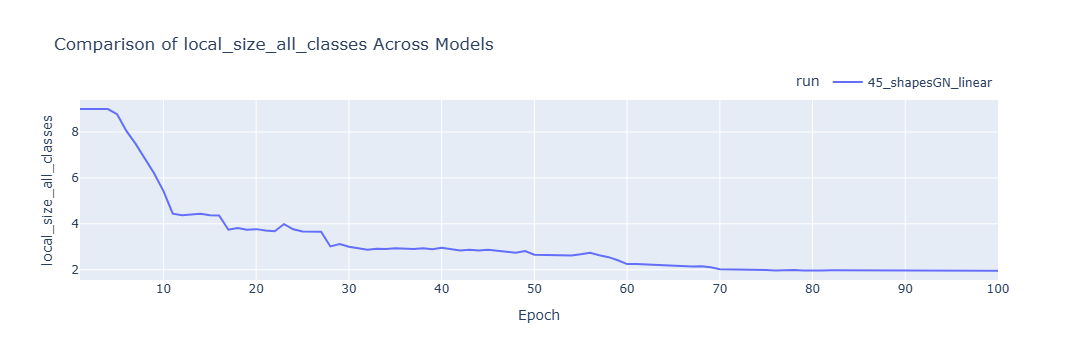

In [44]:
# Compare models if we have multiple runs
if len(run_dirs) > 1:
    print("\nComparing models...")
    # Compare test accuracy
    compare_models(run_dirs, eval_results_dir, metric='test_top1_acc')
    # Compare number of non-zero prototypes
    compare_models(run_dirs, eval_results_dir, metric='num_nonzero_prototypes')
    # Compare local size for all classes
    compare_models(run_dirs, eval_results_dir, metric='local_size_all_classes')

## Plotting test accuracy